In [2]:
import time
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
import PIL.Image as Image

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion

In [3]:
data = pd.read_csv('data/train.csv', sep="\t")
# test_data = pd.read_csv('data/test1.csv', sep="\t")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474710 entries, 0 to 474709
Data columns (total 8 columns):
train_id             474710 non-null int64
name                 474710 non-null object
item_condition_id    474710 non-null int64
category_name        472655 non-null object
brand_name           272297 non-null object
price                474710 non-null float64
shipping             474710 non-null int64
item_description     474708 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 29.0+ MB


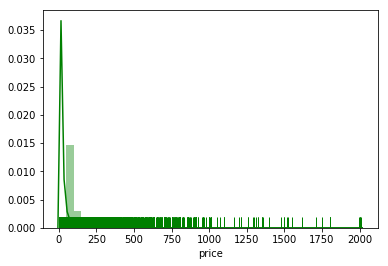

In [5]:
# 绘制price柱形图
width = [50, 100, 150, 200, 250, 300, 350]
sns.distplot(data['price'], color = 'g', rug = True, bins = [w for w in width])

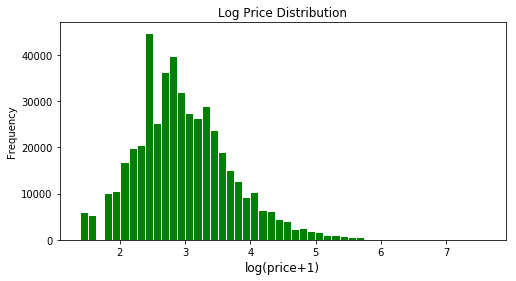

In [7]:
# 经过np.log压缩后绘制price柱形图
plt.xlabel('log(price+1)', fontsize = 12)
plt.title('Log Price Distribution', fontsize = 12)
np.log(data['price'] + 1).plot.hist(bins = 50, figsize = (8, 4), edgecolor = 'white', color = 'g')

In [9]:
y = data['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data,y, test_size = 0.3)

In [11]:
y_train = np.log1p(y_train)

In [12]:
df = pd.concat([X_train, X_test], axis=0)

In [13]:
def featureProcessing(df):

    # delete the data that will not be used
#     df = df.drop(['test_id'], axis=1)
    df = df.drop(['price', 'train_id'], axis=1)
    # deal with the missing value with a default value
    df['category_name'] = df['category_name'].fillna('No/No/No').astype(str)
    df['brand_name'] = df['brand_name'].fillna('missing').astype(str)
    df['item_description'] = df['item_description'].fillna('No')
    # convert the data : int -> str
    df['shipping'] = df['shipping'].astype(str)
    df['item_condition_id'] = df['item_condition_id'].astype(str)

    return df
df = featureProcessing(df)
df.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
243388,Bruce Springsteen Sweatshirt,3,Women/Tops & Blouses/Other,missing,0,"Size medium Back In The USA, Bruce Springsteen..."
221704,Hello kitty house shoes size 11-12,3,Kids/Girls 2T-5T/Shoes,missing,0,Shoes are in good condition
429828,MAC lightbulb Tinted Cream,2,Beauty/Makeup/Face,MAC,1,SPF 30 in color light swatched once to check c...
263455,Stunning unicorn,2,Vintage & Collectibles/Jewelry/Pendant,missing,0,#1. Fantasy unicorn horse Mystical magical dre...
136311,Forever 21 Choker,4,Women/Jewelry/Necklaces,FOREVER 21,0,No description yet


In [14]:
# 输出列类型
print(df.astype('object').describe().transpose())

                    count  unique  \
name               474710  419453   
item_condition_id  474710       5   
category_name      474710    1181   
brand_name         474710    3502   
shipping           474710       2   
item_description   474710  420552   

                                                              top    freq  
name                                                       Bundle     699  
item_condition_id                                               1  205397  
category_name      Women/Athletic Apparel/Pants, Tights, Leggings   19232  
brand_name                                                missing  202413  
shipping                                                        0  261676  
item_description                               No description yet   26391  


In [15]:
# 二元属性shipping的分布比例
print(df['shipping'].value_counts() / len(df))

0    0.551233
1    0.448767
Name: shipping, dtype: float64


In [16]:
# 查看数据集的每个特征的取值个数
print(df.apply(lambda x: x.nunique()))

name                 419453
item_condition_id         5
category_name          1181
brand_name             3502
shipping                  2
item_description     420552
dtype: int64


In [18]:
def split_cat(text):
    return text.split("/")
df['cat1'], df['cat2'], df['cat3'] = \
zip(*df['category_name'].apply(lambda x: split_cat(x)))
df.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,cat1,cat2,cat3
243388,Bruce Springsteen Sweatshirt,3,Women/Tops & Blouses/Other,missing,0,"Size medium Back In The USA, Bruce Springsteen...",Women,Tops & Blouses,Other
221704,Hello kitty house shoes size 11-12,3,Kids/Girls 2T-5T/Shoes,missing,0,Shoes are in good condition,Kids,Girls 2T-5T,Shoes
429828,MAC lightbulb Tinted Cream,2,Beauty/Makeup/Face,MAC,1,SPF 30 in color light swatched once to check c...,Beauty,Makeup,Face
263455,Stunning unicorn,2,Vintage & Collectibles/Jewelry/Pendant,missing,0,#1. Fantasy unicorn horse Mystical magical dre...,Vintage & Collectibles,Jewelry,Pendant
136311,Forever 21 Choker,4,Women/Jewelry/Necklaces,FOREVER 21,0,No description yet,Women,Jewelry,Necklaces


In [19]:
# 查看切分后的cat1的取值的概率
print(df['cat1'].value_counts() / len(df['cat1']))

Women                     0.448071
Beauty                    0.140475
Kids                      0.115285
Electronics               0.082659
Men                       0.063060
Home                      0.045744
Vintage & Collectibles    0.031404
Other                     0.030817
Handmade                  0.020960
Sports & Outdoors         0.017196
No                        0.004329
Name: cat1, dtype: float64


Text(0.5,1,'Count of shipping by cat1')

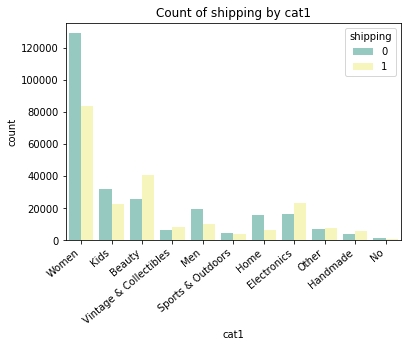

In [20]:
# 通过cat1绘制二元特征shipping的柱形分布图
ax = sns.countplot(x = "cat1", hue = "shipping", data = df, palette = "Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = "right")
ax.set_title('Count of shipping by cat1')

Text(0.5,0,'Number of Items')

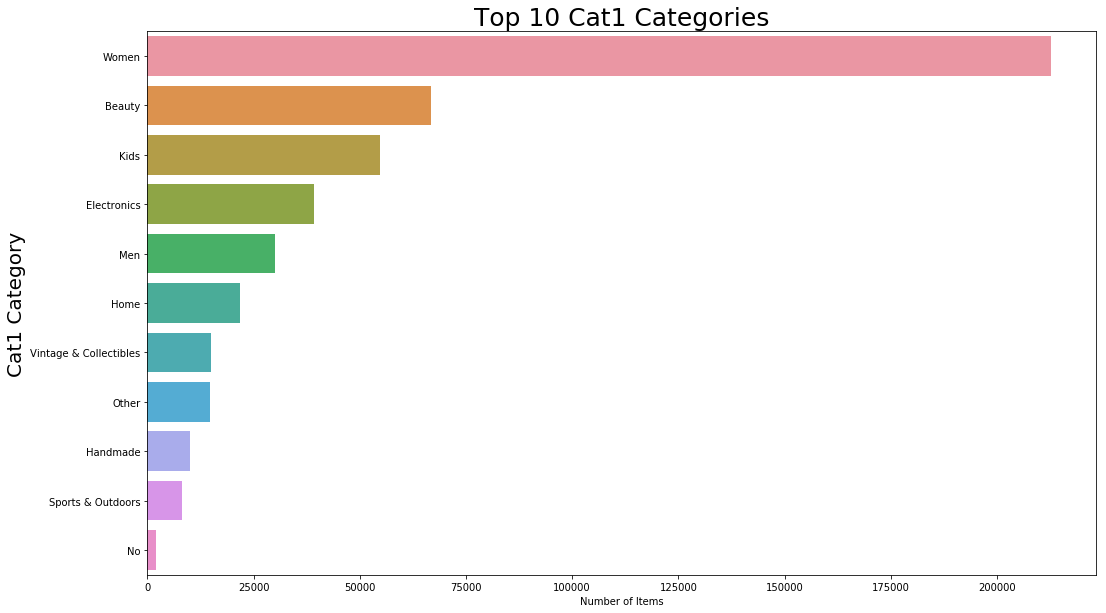

In [23]:
# Category切分之后的第一部分的出现次数最多的前10个
plt.figure(figsize = (17, 10))
sns.countplot(y = df['cat1'], order = df['cat1'].value_counts().index, orient = 'v')
plt.title('Top 10 Cat1 Categories', fontsize = 25)
plt.ylabel('Cat1 Category', fontsize = 20)
plt.xlabel('Number of Items')

Text(0.5,1,'Top 20 Brand Distribution')

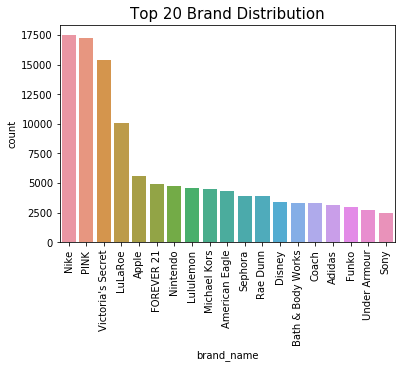

In [24]:
# Brand按照出现次数排序的前20个
b20 = df['brand_name'].value_counts()[1 : 20].reset_index().rename(columns = {'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x = "brand_name", y = "count", data = b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Top 20 Brand Distribution', fontsize = 15)

Text(0.5,1,'Count of each item condition by cat1')

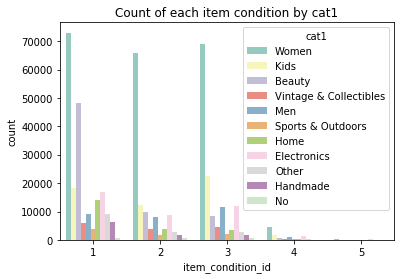

In [28]:
# 通过cat1统计每个不同量出现次数
ax = sns.countplot(x = "item_condition_id", hue = "cat1", data = df, palette = "Set3")
ax.set_title('Count of each item condition by cat1')

Text(0.5,1,'Top 20 Brand')

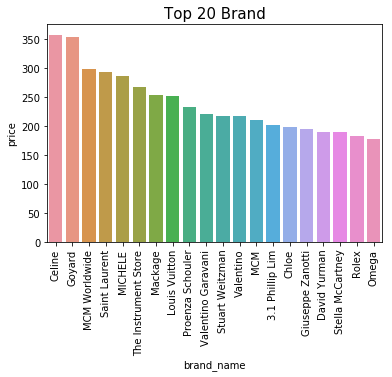

In [26]:
# Brand按照价格排序的前20个
top_20_exp_brand = pd.DataFrame(data.groupby(['brand_name'],as_index = True).std()['price'].sort_values(ascending = False)[0 : 20]).reset_index()
ax = sns.barplot(x = "brand_name", y = "price", data = top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Top 20 Brand', fontsize = 15)

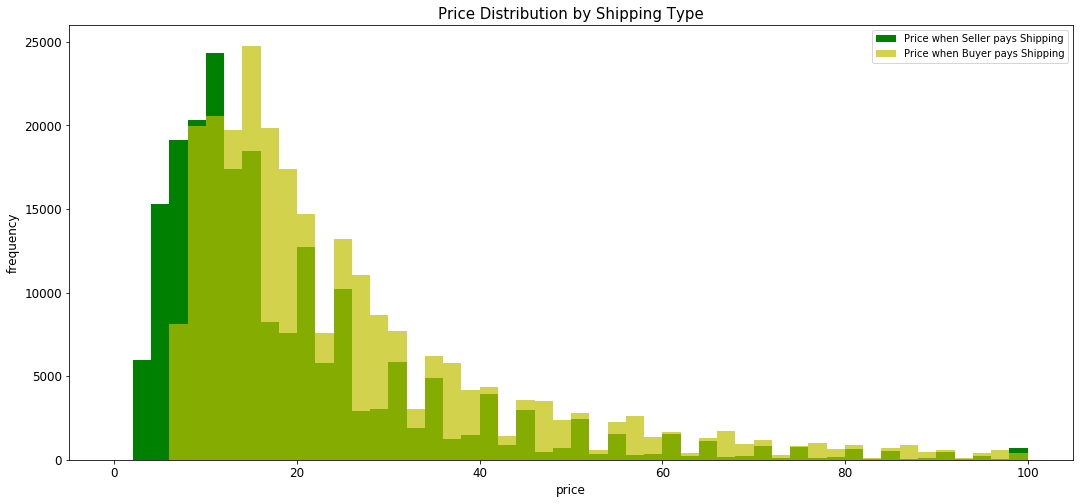

In [22]:
# 通过shipping绘制price的柱形分布图，查看shipping和price的相关性
shipping_by_buyer = data[data['shipping'] == 0]['price']
shipping_by_seller = data[data['shipping'] == 1]['price']
fig, ax = plt.subplots(figsize = (18, 8))
ax.hist(shipping_by_seller, color = 'g', alpha = 1.0, bins = 50, range = [0, 100],label = 'Price when Seller pays Shipping')
ax.hist(shipping_by_buyer, color = 'y', alpha = 0.7, bins = 50, range = [0, 100],label = 'Price when Buyer pays Shipping')
plt.xlabel('price', fontsize = 12)
plt.ylabel('frequency', fontsize = 12)
plt.title('Price Distribution by Shipping Type', fontsize = 15)
plt.tick_params(labelsize = 12)
plt.legend()

Text(0.5,1,'Count of each item condition')

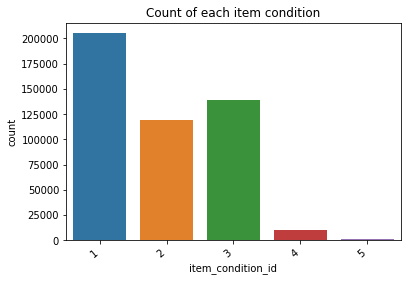

In [27]:
# 统计item_condition不同量出现的次数
ax = sns.countplot('item_condition_id', data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = "right")
ax.set_title('Count of each item condition')

In [11]:
df['brand_name_cat'] = df['brand_name'].str.cat(df['category_name'])

In [12]:
df['brand_name_cat1'] = df['brand_name'].str.cat(df['cat1'])

In [13]:
df['brand_name_cat2'] = df['brand_name'].str.cat(df['cat2'])
df['brand_name_cat3'] = df['brand_name'].str.cat(df['cat3'])

In [14]:
df['brand_name_id'] = df['brand_name'].str.cat(df['item_condition_id'])

In [15]:
df['bn_id_shipping'] = df['brand_name'].str.cat(df['item_condition_id'].str.cat(df['shipping']))

In [16]:
df['bn_cat1_id_shipping'] = df['bn_id_shipping'].str.cat(df['cat1'])
df['bn_cat2_id_shipping'] = df['bn_id_shipping'].str.cat(df['cat2'])
df['bn_cat3_id_shipping'] = df['bn_id_shipping'].str.cat(df['cat3'])

In [17]:
df['cat12'] = df['cat1'].str.cat(df['cat2'])
df['cat23'] = df['cat2'].str.cat(df['cat3'])
df['cat13'] = df['cat1'].str.cat(df['cat3'])

In [18]:
df['bn_cat23_id_shipping'] = df['brand_name']+df['cat23']+df['item_condition_id']+df['shipping']
df['bn_cat12_id_shipping'] = df['brand_name']+df['cat12']+df['item_condition_id']+df['shipping']
df['bn_cat13_id_shipping'] = df['brand_name']+df['cat13']+df['item_condition_id']+df['shipping']

In [19]:
df['text'] = df['item_description'].fillna('') + ' ' + df['name'].fillna('') + ' ' + df['brand_name'].fillna('')

In [20]:
df['brand_name_name'] = df['brand_name'].fillna('') + ' ' + df['name'].fillna('')

In [21]:
df['name_cat1'] = df['name'].fillna('') + ' ' + df['cat1']
df['name_cat2'] = df['name'].fillna('') + ' ' + df['cat2']
df['name_cat3'] = df['name'].fillna('') + ' ' + df['cat3']
df['name_cat'] = df['name'].fillna('') + ' ' + df['category_name']

In [22]:
df['name_cat23'] = df['name'].fillna('') + ' ' + df['cat2'] + ' ' + df['cat3']

In [23]:
df['brand_name_desc'] = df['brand_name'] + ' ' + df['item_description'] 

In [24]:
df['id_shipping'] = df['item_condition_id']+df['shipping']

In [25]:
df['cat1_desc'] = df['cat1'] + ' ' + df['item_description']
df['cat2_desc'] = df['cat2'] + ' ' + df['item_description']
df['cat3_desc'] = df['cat3'] + ' ' + df['item_description']

In [26]:
df['cat1_id_shipping'] = df['cat1'] + df['item_condition_id'] + df['shipping']
df['cat2_id_shipping'] = df['cat2'] + df['item_condition_id'] + df['shipping']
df['cat3_id_shipping'] = df['cat3'] + df['item_condition_id'] + df['shipping']

In [27]:
df.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,cat1,cat2,cat3,brand_name_cat,...,name_cat,name_cat23,brand_name_desc,id_shipping,cat1_desc,cat2_desc,cat3_desc,cat1_id_shipping,cat2_id_shipping,cat3_id_shipping
156871,Cream Floral Tank Top,3,"Women/Tops & Blouses/Tank, Cami",missing,0,No description yet,Women,Tops & Blouses,"Tank, Cami","missingWomen/Tops & Blouses/Tank, Cami",...,Cream Floral Tank Top Women/Tops & Blouses/Tan...,"Cream Floral Tank Top Tops & Blouses Tank, Cami",missing No description yet,30,Women No description yet,Tops & Blouses No description yet,"Tank, Cami No description yet",Women30,Tops & Blouses30,"Tank, Cami30"
239558,"5.25"" Lizard Glass Pipe",1,Vintage & Collectibles/Collectibles/Glass,missing,1,NEW NEVER USED!!!,Vintage & Collectibles,Collectibles,Glass,missingVintage & Collectibles/Collectibles/Glass,...,"5.25"" Lizard Glass Pipe Vintage & Collectibles...","5.25"" Lizard Glass Pipe Collectibles Glass",missing NEW NEVER USED!!!,11,Vintage & Collectibles NEW NEVER USED!!!,Collectibles NEW NEVER USED!!!,Glass NEW NEVER USED!!!,Vintage & Collectibles11,Collectibles11,Glass11
426564,FREE SHIP The Egypt Game,3,Other/Books/Children's Books,missing,1,Title: The Egypt Game Author: Zilpha Keattey S...,Other,Books,Children's Books,missingOther/Books/Children's Books,...,FREE SHIP The Egypt Game Other/Books/Children'...,FREE SHIP The Egypt Game Books Children's Books,missing Title: The Egypt Game Author: Zilpha K...,31,Other Title: The Egypt Game Author: Zilpha Kea...,Books Title: The Egypt Game Author: Zilpha Kea...,Children's Books Title: The Egypt Game Author:...,Other31,Books31,Children's Books31
206767,Denim Tutu Dress 4T,1,Kids/Girls 2T-5T/Dresses,missing,1,Beautiful denim tutu dress. Featuring a denim ...,Kids,Girls 2T-5T,Dresses,missingKids/Girls 2T-5T/Dresses,...,Denim Tutu Dress 4T Kids/Girls 2T-5T/Dresses,Denim Tutu Dress 4T Girls 2T-5T Dresses,missing Beautiful denim tutu dress. Featuring ...,11,Kids Beautiful denim tutu dress. Featuring a d...,Girls 2T-5T Beautiful denim tutu dress. Featur...,Dresses Beautiful denim tutu dress. Featuring ...,Kids11,Girls 2T-5T11,Dresses11
231766,2 piercing kit disposables,1,Women/Other/Other,missing,1,2 brand new disposable ear nose piercing unit ...,Women,Other,Other,missingWomen/Other/Other,...,2 piercing kit disposables Women/Other/Other,2 piercing kit disposables Other Other,missing 2 brand new disposable ear nose pierci...,11,Women 2 brand new disposable ear nose piercing...,Other 2 brand new disposable ear nose piercing...,Other 2 brand new disposable ear nose piercing...,Women11,Other11,Other11


In [28]:
drops = ['cat1_id_shipping','cat2_id_shipping','cat3_id_shipping','brand_name_cat','name_cat3','name_cat23','brand_name_desc','id_shipping','cat1_desc','cat2_desc','cat3_desc','bn_cat12_id_shipping','bn_cat13_id_shipping','cat12','cat13','bn_cat3_id_shipping','bn_cat2_id_shipping','bn_cat1_id_shipping','bn_id_shipping','brand_name_id','name', 'item_description', 'cat1','cat2','cat3','cat23','name_cat1','name_cat', 'brand_name_cat1','brand_name_cat2','brand_name_cat3']
df_ = df.drop(drops, axis=1)
df_.head()

,item_condition_id,category_name,brand_name,shipping,bn_cat23_id_shipping,text,brand_name_name,name_cat2
156871,3,"Women/Tops & Blouses/Tank, Cami",missing,0,"missingTops & BlousesTank, Cami30",No description yet Cream Floral Tank Top missing,missing Cream Floral Tank Top,Cream Floral Tank Top Tops & Blouses
239558,1,Vintage & Collectibles/Collectibles/Glass,missing,1,missingCollectiblesGlass11,"NEW NEVER USED!!! 5.25"" Lizard Glass Pipe missing","missing 5.25"" Lizard Glass Pipe","5.25"" Lizard Glass Pipe Collectibles"
426564,3,Other/Books/Children's Books,missing,1,missingBooksChildren's Books31,Title: The Egypt Game Author: Zilpha Keattey S...,missing FREE SHIP The Egypt Game,FREE SHIP The Egypt Game Books
206767,1,Kids/Girls 2T-5T/Dresses,missing,1,missingGirls 2T-5TDresses11,Beautiful denim tutu dress. Featuring a denim ...,missing Denim Tutu Dress 4T,Denim Tutu Dress 4T Girls 2T-5T
231766,1,Women/Other/Other,missing,1,missingOtherOther11,2 brand new disposable ear nose piercing unit ...,missing 2 piercing kit disposables,2 piercing kit disposables Other


In [29]:
default_preprocessor = CountVectorizer().build_preprocessor()

In [30]:
def build_preprocessor_1(field):
    field_idx = list(df_.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

In [31]:
vectorizer = FeatureUnion([
    ('category_name', CountVectorizer(token_pattern='.+', preprocessor=build_preprocessor_1('category_name'))),
    ('brand_name', CountVectorizer(token_pattern='.+',  preprocessor=build_preprocessor_1('brand_name'))),
    ('bn_cat23_id_shipping', CountVectorizer(token_pattern='.+', preprocessor=build_preprocessor_1('bn_cat23_id_shipping'))),
    ('item_condition_id', CountVectorizer(token_pattern='\d+', preprocessor=build_preprocessor_1('item_condition_id'))),
    ('text', TfidfVectorizer(ngram_range=(1, 2),max_features=200000, preprocessor=build_preprocessor_1('text'))),
    ('brand_name_name', TfidfVectorizer(ngram_range=(1, 2), max_features=200000, preprocessor=build_preprocessor_1('brand_name_name'))),
    ('name_cat2', TfidfVectorizer(ngram_range=(1, 2), max_features=200000, preprocessor=build_preprocessor_1('name_cat2'))),
])

In [32]:
df_.head()

,item_condition_id,category_name,brand_name,shipping,bn_cat23_id_shipping,text,brand_name_name,name_cat2
156871,3,"Women/Tops & Blouses/Tank, Cami",missing,0,"missingTops & BlousesTank, Cami30",No description yet Cream Floral Tank Top missing,missing Cream Floral Tank Top,Cream Floral Tank Top Tops & Blouses
239558,1,Vintage & Collectibles/Collectibles/Glass,missing,1,missingCollectiblesGlass11,"NEW NEVER USED!!! 5.25"" Lizard Glass Pipe missing","missing 5.25"" Lizard Glass Pipe","5.25"" Lizard Glass Pipe Collectibles"
426564,3,Other/Books/Children's Books,missing,1,missingBooksChildren's Books31,Title: The Egypt Game Author: Zilpha Keattey S...,missing FREE SHIP The Egypt Game,FREE SHIP The Egypt Game Books
206767,1,Kids/Girls 2T-5T/Dresses,missing,1,missingGirls 2T-5TDresses11,Beautiful denim tutu dress. Featuring a denim ...,missing Denim Tutu Dress 4T,Denim Tutu Dress 4T Girls 2T-5T
231766,1,Women/Other/Other,missing,1,missingOtherOther11,2 brand new disposable ear nose piercing unit ...,missing 2 piercing kit disposables,2 piercing kit disposables Other


In [33]:
X_ = vectorizer.fit_transform(df_.values)

MemoryError: 

In [ ]:
# 传入数据集进行处理

# 训练数据的行数
nrow_train = X_train.shape[0]
# nrow_train = train_data.shape[0]
# 处理后的训练数据
X_train = X_[:nrow_train]
# 处理后的测试数据
X_test = X_[nrow_train:]

In [ ]:
from sklearn.metrics import mean_squared_log_error
def ridgeClassify(train_data, train_label, alpha):
    ridgeClf = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=alpha,
        max_iter=550,
        normalize=False,
        tol=0.01)
    # 训练
    ridgeClf.fit(train_data, train_label)
    return ridgeClf

In [ ]:
from sklearn.metrics import mean_squared_log_error
ridgeClf = ridgeClassify(X_train, y_train, 3.7)
# 结果预测
test_price = ridgeClf.predict(X_test)


In [ ]:
mean_squared_log_error(y_test, np.expm1(test_price))

In [ ]:
res_alpha = []
for alpha in [3,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4]:
    ridgeClf = ridgeClassify(X_train, y_train, alpha)
# 结果预测
    test_price = ridgeClf.predict(X_test)
    msle = mean_squared_log_error(y_test, np.expm1(test_price))
    res_alpha.append(msle)

In [ ]:
mean_squared_log_error(np.expm1(y_test), np.expm1(test_price))
# mean_squared_log_error(true_price, np.expm1(test_price))

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
def regressor_model():  #Keras wrapper always requires function as an argument so creating this function.
    # Creating my model:
    model = Sequential()
    model.add(Dense(units = 8,kernel_initializer = 'uniform', activation = 'relu', input_dim = 449780))
    model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    # model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
    # model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, init='uniform'))
    # Compiling my model:
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

from sklearn.pipeline import Pipeline

estimators = []
estimators.append(('mlp', KerasRegressor(build_fn= regressor_model, epochs=5, validation_data=(X_test, y_test),verbose=1)))

pipeline = Pipeline(estimators)

pipeline.fit(X_train,y_train)


In [ ]:
target_pred = pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [61]:
mean_squared_log_error(y_test, np.expm1(target_pred))

0.22797919787322626

In [1]:
import lightgbm as lgb
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression', # 目标函数
    'metric': {'l2','mse'},  # 评估函数
    'num_leaves': 63,   # 叶子节点数
    'learning_rate': 0.1,  # 学习速率
    'feature_fraction': 1, # 建树的特征选择比例
    'bagging_fraction': 0.9, # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1, # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
    'num_threads': 20,
    'batch_size': 32
}



lgb_train = lgb.Dataset(X_train, y_train) # 将数据保存到LightGBM二进制文件将使加载更快
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)  # 创建验证数据
gbm = lgb.train(params,lgb_train,num_boost_round=2000,valid_sets=lgb_eval,early_stopping_rounds=15) # 训练数据需要参数列
target_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


NameError: name 'lgb' is not defined

In [48]:
test_price_ = (test_price+test_price1+test_price2)/3
np.expm1(test_price_)

array([26.54491839,  9.48372781, 23.45109831, ...,  8.7466514 ,
       14.64856352,  9.19845095])

In [47]:
np.expm1(test_price)

array([26.75759829,  9.51020486, 23.71921639, ...,  8.81423887,
       14.74164574,  9.17771885])

In [36]:
np.expm1(test_price1)

array([26.63095679,  9.50353327, 23.25753173, ...,  8.74047316,
       14.65913682,  9.237358  ])

In [46]:
np.expm1(test_price2)

array([26.24875475,  9.43759914, 23.37888328, ...,  8.68566898,
       14.54552804,  9.18038715])

In [49]:
res = np.expm1(test_price_)
res1 = pd.DataFrame(res)
# temp = pd.read_csv('data/test1.csv', sep="\t")

In [50]:
res1.columns=['price']
res1 = pd.concat([test_data['test_id'],res1['price']], axis=1)

In [43]:
np.expm1(test_price1)

array([26.63095679,  9.50353327, 23.25753173, ...,  8.74047316,
       14.65913682,  9.237358  ])

In [44]:
np.expm1(test_price)

array([26.75759829,  9.51020486, 23.71921639, ...,  8.81423887,
       14.74164574,  9.17771885])

In [51]:
res1

,test_id,price
0,0,26.544918
1,1,9.483728
2,2,23.451098
3,3,23.190654
4,4,7.337061
5,5,10.530961
6,6,10.149368
7,7,18.812928
8,8,7.382025
9,9,27.889915


In [52]:
res1.to_csv("res2.csv", index=False,sep="\t")

In [56]:
res2 = pd.read_csv('res2.csv', sep='\t')
res2.head()

,test_id,price
0,0,26.544918
1,1,9.483728
2,2,23.451098
3,3,23.190654
4,4,7.337061


In [57]:
res3 = pd.read_csv('res1.csv', sep='\t')
res3.head()

,test_id,price
0,0,26.190936
1,1,9.411546
2,2,20.807203
3,3,22.742082
4,4,7.375566
